# FAA: Práctica 2

### Autores: David Cabornero Pascual y Mario García Pascual

## 0. Introducción

La práctica 2 consiste en implementar en Python dos nuevos clasificadores que se sumarán al actual clasificador de Naive-Bayes: regresión logística y vecinos próximos. Posteriormente, comprobamos cómo se comportan las funciones de scipy respecto a nuestras implementaciones. Finalmente, se hace un análisis ROC de todos los clasificadores implementados hasta el momento.

A continuación añadimos todas las librerías que se usarán en el notebook y declaramos los datos que se van a usar.

In [1]:
import numpy as np

from Clasificador import Clasificador,ClasificadorRegresionLogistica,ClasificadorNaiveBayes,ClasificadorVecinosProximos
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple, ValidacionCruzada

from astropy.table import QTable, Table, Column

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

dataWDBC = Datos('wdbc.data', predNominal=True)
dataIndians = Datos('pima-indians-diabetes.data', predNominal=False)

## 1. Vecinos próximos

Se ha implementado el clasificador de vecinos próximos al que se le deben indicar tres parámetros: el número de vecinos, la distancia utilizada y si se quiere normalizar. Los dos últimos parámetros son opcionales, y si no se menciona la distancia será la euclidea y se normalizarán los datos.

Dado que este algoritmo tiene bastante más coste de predicción que regresión logística, no se ejecutará un gran número de veces. Por ello, para conseguir que ese número de veces arroje un error consistente se va a realizar validación cruzada en toda la sección.

A continuación analizaremos las dos bases de datos que se nos han encargado. Se seguirá el siguiente procedimiento:
* Análisis de la normalización: variando el número de vecinos (1,5,11,21) y la distancia utilizada se muestra si la normalización da o no unos resultados significativamente mejores.
* Análisis de los parámetros: se muestran en una gráfica los errores obtenidos para un cierto número de vecinos y una cierta distancia y se evalúan dichos resultados. En este apartado ya solo se trabaja con los datos normalizados, ya que en el peor de los casos la normalización no ayudará demasiado a obtener mejores resultados, pero en ningún caso debería empeorarlos.

In [18]:
# Devuelve tres arrays: datos normalizados, sin normalizar y la diferencia entre ambos. Prec es la precisión de
# decimales que se quiere en los resultados
def data_knn(distancias,vecinos,data,numEx=5,prec=5):
    particionado = ValidacionCruzada(numEx)

    datosTablaN = [vecinos,]
    datosTabla = [vecinos,]

    for dist in distancias:
        lstN = []
        lst = []
        for k in vecinos:
            # Normalizado
            clN = ClasificadorVecinosProximos(k,distancia=dist)
            erroresN = clN.validacion(particionado,data)
            # Sin normalizar
            cl = ClasificadorVecinosProximos(k,distancia=dist,normaliza=False)
            errores = cl.validacion(particionado,data)
            # Añadimos a las columnas
            lstN.append(np.around(np.mean(erroresN),prec))
            lst.append(np.around(np.mean(errores),prec))
        datosTabla.append(lst)
        datosTablaN.append(lstN)
    diff = [vecinos,]+list(np.around((np.array(datosTabla)-np.array(datosTablaN)),prec)[1:])
    return datosTablaN,datosTabla,diff

# Impresión de las tablas
def print_knn(datosTablaN,datosTabla,diff,distancias):
    header = ['Num. Vecinos'] + distancias
    
    print('Sin normalizar:')
    t = Table(datosTabla,names=header)
    print(t)
    print('\n')

    print('Normalizando:')
    tN = Table(datosTablaN,names=header)
    print(tN)
    print('\n')

    print('Diferencias:') 
    tDif = Table(diff,names=header)
    print(tDif)

# Graficación de resultados
def plot_knn(datosTablaN,title):
    vecinos = np.array(datosTablaN)[0]
    datos = np.array(datosTablaN)[1:]

    # Distancia euclidea
    plt.plot(vecinos,datos[0],'r')
    # Manhattan
    plt.plot(vecinos,datos[1],'b')
    # Mahalanobis
    plt.plot(vecinos,datos[2],'g')

    red = mpatches.Patch(color='red', label='Euclidea')
    blue = mpatches.Patch(color='blue', label='Manhattan')
    green = mpatches.Patch(color='green', label='Mahalanobis')
    
    plt.xticks(vecinos)
    plt.legend(handles=[red,blue,green])
    plt.xlabel('Número de vecinos')
    plt.ylabel('Tasa de error')
    plt.title(title)

    plt.show()

# Parámetros que se van a variar
distancias = ['euclidea','manhattan','mahalanobis']
vecinos = [1,5,11,21]

### 1.1. WDBC

A continuación se muestran tres tablas. En ellas, se muestra el error medio obtenido en la validación cruzada en el caso de que se normalice y de que no se normalice. Además se añade una tabla que muestra la diferencia entre el error cuando no se normaliza y cuando se normaliza. En esta tabla, un dato positivo indica que ha dado menos error la normalización.

Se avisa al lector de que la ejecución de estas funciones puede tardar unos cuantos minutos; rogamos paciencia.

In [19]:
datosTablaN,datosTabla,diff = data_knn(distancias,vecinos,dataWDBC)
print_knn(datosTablaN,datosTabla,diff,distancias)

Sin normalizar:
Num. Vecinos euclidea manhattan mahalanobis
------------ -------- --------- -----------
           1   0.0791    0.0824     0.17938
           5  0.07379   0.06695     0.19843
          11  0.06518   0.05963      0.2254
          21  0.07733   0.07013     0.29474


Normalizando:
Num. Vecinos euclidea manhattan mahalanobis
------------ -------- --------- -----------
           1  0.08984   0.07892     0.17071
           5  0.07568    0.0578      0.1894
          11  0.06317   0.06683     0.22083
          21  0.06878   0.06329     0.27057


Diferencias:
Num. Vecinos euclidea manhattan mahalanobis
------------ -------- --------- -----------
           1 -0.01074   0.00348     0.00867
           5 -0.00189   0.00915     0.00903
          11  0.00201   -0.0072     0.00457
          21  0.00855   0.00684     0.02417


Como se puede observar, la diferencia de error entre la normalización y la no-normalización es prácticamente nula (menor del 1% en casi todos los casos). De esto se puede deducir que en nuestra base de datos WDBC no hay grandes cambios de escala que afecten al comportamiento del algoritmo de vecinos próximos.

Tras ver esto, nos quedamos con los datos normalizados por simplicidad y analizaremos los resultados obtenidos arriba mediante una graficación de los errores.

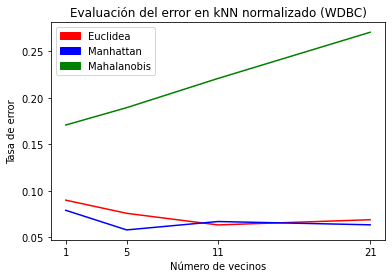

In [20]:
plot_knn(datosTablaN,'Evaluación del error en kNN normalizado (WDBC)')

Hay una conclusión que salta a la vista: la distancia de Mahalanobis es la peor de todas en este dataset. Además, parece que según se escogen más vecinos para el algoritmo el error empeora. En cambio, la distancia de Manhattan y la euclidea se comportan de manera similar, siendo algo mejor la de Manhattan.

Respecto a los vecinos, parece que cada uno tiene un mínimo en un número distinto. Si nos centramos en Manhattan (la distancia que da mejores resultados) parece que alcanza un mínimo de error en 5 vecinos, aumentando ligeramente si se toman más o menos vecinos. En cambio, la euclidea encuentra su mínimo en 11 vecinos y Mahalanobis en 1 vecino. Sin embargo, sobretodo la distancia euclidea y la de Manhattan parecen líneas muy ajustadas, y es posible que en algunas simulaciones encuentren su mínimo en otro punto.

### 1.2. Indians

A continuación procedemos a hacer los mismos cálculos con la segunda base de datos. De nuevo avisamos de que la ejecución de vecinos tarda especialmente, así que rogamos paciencia o fe en los resultados mostrados.

In [25]:
datosTablaN,datosTabla,diff = data_knn(distancias,vecinos,dataIndians)
print_knn(datosTablaN,datosTabla,diff,distancias)

Sin normalizar:
Num. Vecinos euclidea manhattan mahalanobis
------------ -------- --------- -----------
           1  0.30862    0.2902     0.31508
           5  0.28653   0.26403        0.25
          11  0.26287   0.26812     0.25246
          21  0.25385   0.24085     0.25784


Normalizando:
Num. Vecinos euclidea manhattan mahalanobis
------------ -------- --------- -----------
           1  0.32169   0.30442     0.29806
           5  0.28783    0.2863     0.27971
          11  0.25003   0.25003     0.25118
          21  0.26682   0.25515      0.2642


Diferencias:
Num. Vecinos euclidea manhattan mahalanobis
------------ -------- --------- -----------
           1 -0.01307  -0.01422     0.01702
           5  -0.0013  -0.02227    -0.02971
          11  0.01284   0.01809     0.00128
          21 -0.01297   -0.0143    -0.00636


De nuevo las escalas no están lo suficientemente dispersas como para que se pueda decir que la normalización está ayudando a la hora de calcular correctamente las predicciones. Aunque nos podemos encontrar mayores fluctuaciones que antes, tras varias ejecuciones hemos concluido que ningún dato parece mejorar o empeorar en su versión normalizada.

Tras esto, de nuevo nos quedaremos por simplicidad con los datos normalizados. Procedemos a su graficación para hallar los resultados óptimos.

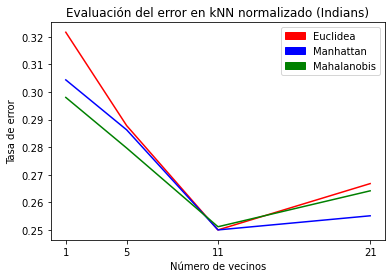

In [26]:
plot_knn(datosTablaN,'Evaluación del error en kNN normalizado (Indians)')

A diferencia de antes, ahora no parece que haya un claro vencedor. Sin embargo, esta database presenta una tasa de error mucho mayor que la anterior (incluso Mahalanobis presentaba menos errores). Podemos sacar dos conclusiones. La primera y más clara es que lo mejor para alcanzar el mínimo error es escoger 11 vecinos. Si escogemos más o menos vecinos el error sube un porcentaje suficientemente elevado como para que no sea despreciable. La segunda conclusión es menos trivial y puede que cambie en otras simulaciones: la distancia euclidea es la peor en este caso.

## 2. Regresión logística

Ahora trataremos el segundo algoritmo de esta práctica: regresión logística mediante el método de la maximización de la verosimilitud. En este caso se pueden indicar tres parámetros opcionales: eta o constante de aprendizaje, número de épocas y normalización de la base de datos.

Aunque no se especifica en el enunciado, hemos decidido normalizar la base de datos utilizada, ya que también se ha hecho en clase de teoría. Se supone que con un número suficiente de épocas la normalización no debería afectar a la clasificación, pero sí que es cierto que una correcta normalización facilita la convergencia del algoritmo.

A diferencia del caso anterior, el algoritmo de regresión logísitica tarda muchísimo menos en ejecutarse. Por ello, se realizarán más ejecuciones y de esta forma obtendremos unos datos más fiables. Por ello, en esta parte se ha optado por trabajar con la validación simple, ya que una validación cruzada garantizaría una máxima independencia de los testSet, pero a su vez serían demasiado pequeños.

El procedimiento a seguir con cada base de datos será el mismo que en el apartado anterior:
* Análisis de la normalización: variando la constante de aprendizaje y el número de épocas se muestra si la normalización da o no unos resultados significativamente mejores. 
* Análisis de los parámetros: se muestran en una gráfica los errores obtenidos para una cierta constante de aprendizaje y un cierto número de épocas y se evalúan dichos resultados. En este apartado ya solo se trabaja con los datos normalizados por simplicidad.

In [41]:
# Obtención de datos
def data_log(constantes,pasos,data,numEx=20,propTest=0.2,prec=5):
    particionado = ValidacionSimple(propTest,numEx)

    datosTablaN = [constantes,]
    datosTabla = [constantes,]

    for paso in pasos:
        lstN = []
        lst = []
        for cte in constantes:
            # Normalizado
            clN = ClasificadorRegresionLogistica(eta=cte,epochs=paso)
            erroresN = clN.validacion(particionado,data)
            # Sin normalizar
            cl = ClasificadorRegresionLogistica(eta=cte,epochs=paso,normaliza=False)
            errores = cl.validacion(particionado,data)
            # Añadimos a las columnas
            lstN.append(np.around(np.mean(erroresN),prec))
            lst.append(np.around(np.mean(errores),prec))
        datosTabla.append(lst)
        datosTablaN.append(lstN)
    diff = [constantes,]+list(np.around((np.array(datosTabla)-np.array(datosTablaN)),prec)[1:])
    return datosTablaN,datosTabla,diff

# Impresión de datos en tablas
def print_log(datosTablaN,datosTabla,diff,pasos):
    header = ['Cte \ Pasos'] + pasos
    
    print('Sin normalizar:')
    t = Table(datosTabla,names=header)
    print(t)
    print('\n')

    print('Normalizando:')
    tN = Table(datosTablaN,names=header)
    print(tN)
    print('\n')

    print('Diferencias:') 
    tDif = Table(diff,names=header)
    print(tDif)
    
def plot_log(datosTablaN,title):
    consts = np.array(datosTablaN)[0]
    datos = np.array(datosTablaN)[1:]

    # 1 PASO
    plt.plot(consts,datos[0],'r')
    # 10 PASOS
    plt.plot(consts,datos[1],'b')
    # 20 PASOS
    plt.plot(consts,datos[2],'y')
    # 50 PASOS
    plt.plot(consts,datos[3],'g')
    # 100 PASOS
    plt.plot(consts,datos[4],'k')

    red = mpatches.Patch(color='red', label='1 paso')
    blue = mpatches.Patch(color='blue', label='10 pasos')
    yellow = mpatches.Patch(color='yellow', label='20 pasos')
    green = mpatches.Patch(color='green', label='50 pasos')
    black = mpatches.Patch(color='black', label='100 pasos')
    
    plt.xscale('log')
    
    plt.legend(handles=[red,blue,yellow,green,black])
    plt.xlabel('Constante de aprendizaje (log)')
    plt.ylabel('Tasa de error')
    plt.title(title)

    plt.show()

constantes = [0.01,0.1,1,5,10,20]
pasos = [1,10,20,50,100]

### 2.1. WDBC

Comenzamos analizando la primera base de datos. Como siempre, comenzamos variando los parámetros para ver el impacto de la normalización.

In [40]:
datosTablaN,datosTabla,diff = data_log(constantes,pasos,dataWDBC,propTest=0.5)
print_log(datosTablaN,datosTabla,diff,pasos)

C:\Users\David\Desktop\Universidad\FAA\Practicas\faa\p2\Clasificador.py:244: RuntimeWarning: overflow encountered in exp
  sig = lambda x: 1/(1+np.exp(-x))


Sin normalizar:
Cte \ Pasos    1       10      20      50     100  
----------- ------- ------- ------- ------- -------
       0.01 0.28785 0.15264 0.16021 0.14085 0.11268
        0.1 0.32764  0.2088 0.17746 0.12782 0.11989
        1.0 0.29665 0.12412 0.20123 0.14824 0.14208
        5.0 0.33926 0.13046 0.17887 0.10264 0.11391
       10.0  0.3331 0.20229  0.1875 0.13996 0.12254
       20.0  0.3463 0.22958 0.12324 0.15194 0.11901


Normalizando:
Cte \ Pasos    1       10      20      50     100  
----------- ------- ------- ------- ------- -------
       0.01 0.30687 0.14419 0.13204 0.13204 0.13081
        0.1 0.30176 0.15651 0.15106 0.12606 0.16039
        1.0 0.35282 0.17271 0.14489 0.13856 0.11831
        5.0 0.33151 0.14789 0.15968 0.14542 0.16743
       10.0 0.39278 0.15194 0.15106 0.13803 0.14595
       20.0     0.3 0.21373 0.16514 0.12764  0.1132


Diferencias:
Cte \ Pasos    1        10       20      50      100   
----------- -------- -------- ------- -------- --------
       0.

Se puede ver ahora un cierto fenómeno. Dejando de un lado las constantes de aprendizaje más altas y la época única (después las comentaremos aparte) parece ser que el impacto de la normalización se nota especialmente cuando hay pocas épocas. Esto es debido a lo que se ha explicado antes: la normalización facilita la convergencia.

Por simplicidad, ahora nos quedaremos con los resultados normalizados y procederemos a analizarlos:

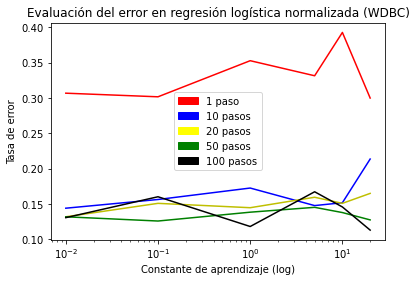

In [42]:
plot_log(datosTablaN,'Evaluación del error en regresión logística normalizada (WDBC)')

Claramente la conclusión que se saca más a la vista es que una época no es suficiente para garantizar la convergencia. A partir de ahí, aunque con 10 épocas se ve que aún se pueden mejorar los resultados ya parecen mostrar una mejoría notable. La segunda conclusión que sacamos es que a partir de 5 la constante de aprendizaje es mala, ya que los resultados empiezan a estar desordenados respecto al número de épocas, mostrando así un cierto 'caos' en la convergencia. También podemos ver que incluso las constantes más bajas muestran muy buenos resultados gracias a la normalización.

Respecto a lo demás, se puede concluir que en este modelo 20 épocas son suficientes. Aunque 10 tampoco está mal, con 20 épocas nos garantizamos una convergencia que parece que no va a presentar mayor mejoría en un mayor número de épocas.

En esta ocasión tenemos una pregunta extra que plantearnos: ¿las constantes de aprendizaje cobran mayor importancia si no se normaliza?

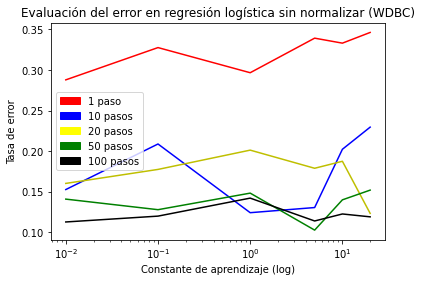

In [44]:
plot_log(datosTabla,'Evaluación del error en regresión logística sin normalizar (WDBC)')

Tenemos las mismas conclusiones de antes respecto a las constantes de aprendizaje altas y a la época única. Sin embargo, notamos dos consecuencias de una convergencia más lenta: ahora solo podemos considerar como 'suficientes' 50 épocas, ya que en las épocas anteriores se deja mucho que desear. 

Además, vemos que ahora las constantes de aprendizaje bajas se castigan. Si no se han escogido épocas suficientes, el error es bastante más alto debido a que aún no ha convergido el resultado. Sin embargo, cuando se ejecutan suficientes épocas y se tiene una constante de aprendizaje muy baja vemos que podemos obtener el resultado más fino de todos a costa de un mayor coste computacional.